In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 6540 assets.


In [16]:
data.head(10)

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMT,ASML,...,GRU,GSCE,GSP,HDLB,HMDCF,HOMU,HWCPZ,HAWLM,HBANP,HFRO-PA
0,125.974464,86.739708,99.687309,238.710358,485.339996,153.288055,92.300003,193.642502,191.466125,477.949158,...,3.5100,17.25,10.9200,6.557615,5.1097,0.55,19.842388,15.62887,18.716362,19.115032
1,127.532021,87.636642,100.920723,240.069351,485.690002,152.861603,92.769997,194.582230,192.433868,483.072815,...,3.4950,17.25,11.4300,6.720678,5.1097,0.55,19.909050,15.62887,18.716362,19.110727
2,123.239037,86.879608,100.710602,242.694153,466.309998,152.326324,90.330002,199.272491,187.359482,468.600525,...,3.5450,17.25,11.4650,7.058459,5.1097,0.55,19.716475,15.62887,18.716362,19.087008
3,127.444374,87.809464,101.688164,244.983932,477.739990,153.188248,95.160004,199.930344,189.635117,479.316132,...,3.4501,17.25,11.4900,7.087579,5.1097,0.55,19.894239,15.62887,18.716362,19.116274
4,128.544388,88.270248,101.971436,245.877502,485.100006,155.184143,94.580002,203.749222,193.733017,486.303741,...,3.5650,17.25,11.6900,7.081756,5.1097,0.55,19.975708,15.62887,18.716362,19.026497
5,125.555862,89.710304,101.267891,242.331146,474.239990,152.879791,97.250000,202.963242,187.385651,485.548584,...,3.5450,17.25,11.5814,7.169112,5.1097,0.55,19.901644,15.62887,18.716362,18.758623
6,125.380676,90.335686,99.440636,240.516129,471.649994,153.378738,95.360001,202.125992,187.376938,491.264862,...,3.9400,17.25,11.8600,7.322120,5.1097,0.55,19.809057,15.62887,18.716362,18.744024
7,127.415154,92.532768,102.464775,240.105194,472.049988,149.386856,91.779999,203.108475,188.728363,491.389099,...,4.1500,17.25,11.8148,7.427643,5.1097,0.55,20.064590,15.62887,18.716362,18.780519
8,125.487740,92.932373,100.942024,238.162506,463.269989,146.891953,90.790001,206.457443,187.446701,520.630066,...,4.0850,17.25,11.9400,7.591791,5.1097,0.55,19.923861,15.62887,18.716362,18.926498
9,123.764717,92.008286,102.097832,236.901642,458.079987,146.175217,88.209999,209.729507,191.718918,504.236298,...,4.1400,17.25,11.7299,7.421782,5.1097,0.55,20.027554,15.62887,18.716362,18.765919


In [17]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [18]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

# 1. Аннуализация ожидаемой доходности (mu)
expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR

# 2. Аннуализация риска (sigma)
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)

# Объединяем результаты в один DataFrame
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

# Сортировка для вывода
asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
UCIX              0.025199  6.035947e-18
WARM              0.025199  6.035947e-18
VCOR              0.025199  6.035947e-18
WBHC              0.025199  6.035947e-18
MULG              0.025199  6.035947e-18

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
EOSS             -5.658339     14.391406
ELIO             -2.452975     15.135011
SECI              0.931093     18.431838
APPB             -5.661648     18.724938
NDTP             -0.296223     20.401293


In [19]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 32

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
ELLKF              0.025199  6.035947e-18
XPTFX              0.043246  6.098673e-03
CCLFX              0.123407  9.506756e-03
NICHX              0.141159  1.149543e-02
PRDEX              0.223496  1.292281e-02
FROPX              0.267259  3.546448e-02
RSF                0.281760  9.812526e-02
PIIVX              0.322518  1.052297e-01
NRSZX              0.352706  1.055189e-01
CET                0.442299  1.216275e-01


In [20]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
ELLKF              0.025199  6.035947e-18         -0.000100          -0.001587
XPTFX              0.043246  6.098673e-03         -0.000100          -0.001587
CCLFX              0.123407  9.506756e-03         -0.000100          -0.001587
NICHX              0.141159  1.149543e-02         -0.000100          -0.001587
PRDEX              0.223496  1.292281e-02         -0.000100          -0.001587
FROPX              0.267259  3.546448e-02          0.001248           0.019817
PIIVX              0.322518  1.052297e-01          0.004458           0.070769
RSF                0.281760  9.812526e-02          0.007187           0.114098
NRSZX              0.352706  1.055189e-01          0.008387           0.133140
LTAFX              0.539107  1.641799e-01          0.008888           0.141099


In [21]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: ELLKF
Годовой VaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

Расположение на карте (σ, E):
Риск (X-координата): 0.0000
Доходность (Y-координата): 0.0252


In [22]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
ELLKF              0.025199  6.035947e-18          -0.001587   
CCLFX              0.123407  9.506756e-03          -0.001587   
NICHX              0.141159  1.149543e-02          -0.001587   
XPTFX              0.043246  6.098673e-03          -0.001587   
PRDEX              0.223496  1.292281e-02          -0.001587   
FROPX              0.267259  3.546448e-02           0.019817   
PIIVX              0.322518  1.052297e-01           0.070769   
NRSZX              0.352706  1.055189e-01           0.133140   
LTAFX              0.539107  1.641799e-01           0.141099   
RSF                0.281760  9.812526e-02           0.114098   

       CVaR (Annual, 95%)  
ELLKF           -0.001587  
CCLFX           -0.001529  
NICHX           -0.000862  
XPTFX           -0.000838  
PRDEX           -0.000656  
FROPX            0.03686

In [23]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: ELLKF
Годовой CVaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: ELLKF
Тикер, предпочтительный по CVaR: ELLKF
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.


Кластеризация активов по комбинированным метрикам риска и доходности (μ, σ, VaR, CVaR)

C:\Users\n.maryakhin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Кластеры присвоены. Количество активов в каждом:
Cluster
0    24
2     5
1     2
3     1
Name: count, dtype: int64


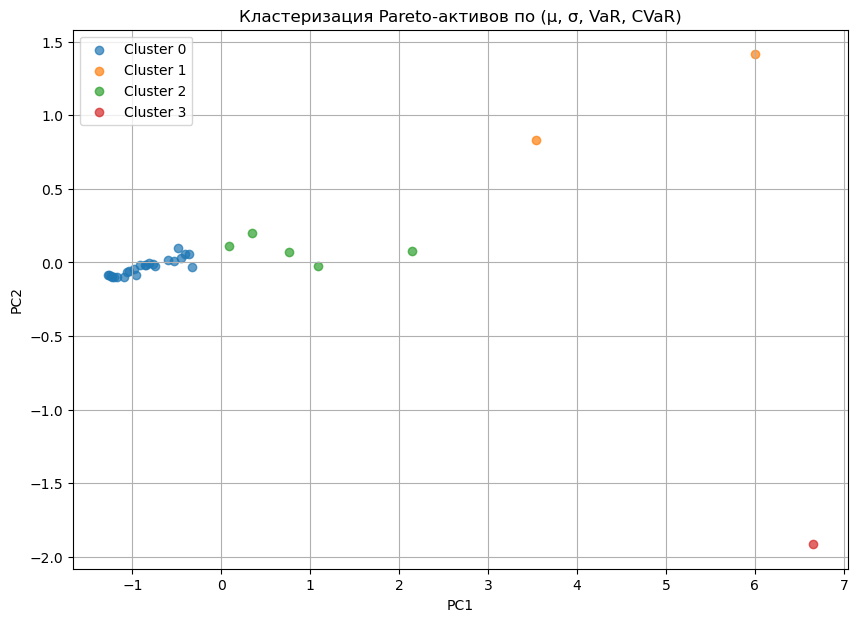


--- Пример активов из каждого кластера ---

Cluster 0:
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  \
ELLKF              0.025199  6.035947e-18           -0.0001   
XPTFX              0.043246  6.098673e-03           -0.0001   
CCLFX              0.123407  9.506756e-03           -0.0001   
NICHX              0.141159  1.149543e-02           -0.0001   
PRDEX              0.223496  1.292281e-02           -0.0001   

       VaR (Annual, 95%)  CVaR (Daily, 95%)  CVaR (Annual, 95%)  Cluster  \
ELLKF          -0.001587          -0.000100           -0.001587        0   
XPTFX          -0.001587          -0.000053           -0.000838        0   
CCLFX          -0.001587          -0.000096           -0.001529        0   
NICHX          -0.001587          -0.000054           -0.000862        0   
PRDEX          -0.001587          -0.000041           -0.000656        0   

            PC1       PC2  
ELLKF -1.270723 -0.085012  
XPTFX -1.263056 -0.088524  
CCLFX -1.237924 -0.09465

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 1. Собираем признаки для кластеризации ---
features = pareto_df[['Expected Return (mu)', 
                      'Risk (sigma)', 
                      'VaR (Annual, 95%)', 
                      'CVaR (Annual, 95%)']]

# --- 2. Масштабирование ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 3. KMeans ---
k = 4  # можно менять
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pareto_df['Cluster'] = clusters

print("\nКластеры присвоены. Количество активов в каждом:")
print(pareto_df['Cluster'].value_counts())

# --- 4. PCA для визуализации ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pareto_df['PC1'] = X_pca[:,0]
pareto_df['PC2'] = X_pca[:,1]

# --- 5. Отображение кластеров ---
plt.figure(figsize=(10,7))
for c in range(k):
    subset = pareto_df[pareto_df['Cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеризация Pareto-активов по (μ, σ, VaR, CVaR)")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Пример активов из каждого кластера ---")
for c in range(k):
    print(f"\nCluster {c}:")
    print(pareto_df[pareto_df['Cluster']==c].head())


Одна из ключевых метрик для анализа максимальной просадки:

MDD = min( P_t / max(P_0..t) - 1 )

Хорошо выявляет “опасные” активы.

In [26]:
# --- Maximum Drawdown (MDD) ---

def calculate_mdd(series):
    """
    series: pd.Series of prices for one ticker.
    Returns: maximum drawdown (negative value).
    """
    running_max = series.cummax()
    drawdowns = series / running_max - 1
    return drawdowns.min()  # минимальное значение (самая глубокая просадка)

# Рассчитаем MDD для всех активов
mdd_values = {}

for ticker in data.columns:
    mdd_values[ticker] = calculate_mdd(data[ticker])

mdd_series = pd.Series(mdd_values, name="MDD")

# Добавляем в таблицу всех метрик
asset_metrics['MDD'] = mdd_series

print("\n--- Топ-10 активов с НАИМЕНЬШЕЙ просадкой (лучшие) ---")
print(asset_metrics.sort_values('MDD', ascending=False).head(10))

print("\n--- Топ-10 активов с НАИБОЛЬШЕЙ просадкой (худшие) ---")
print(asset_metrics.sort_values('MDD').head(10))



--- Топ-10 активов с НАИМЕНЬШЕЙ просадкой (лучшие) ---
       Expected Return (mu)  Risk (sigma)  MDD
UCIX               0.025199  6.035947e-18  0.0
ARCXF              3.305763  3.007436e+00  0.0
CITY               0.025199  6.035947e-18  0.0
WEWA               0.025199  6.035947e-18  0.0
MULG               0.025199  6.035947e-18  0.0
ELLKF              0.025199  6.035947e-18  0.0
DSLVF              0.025199  6.035947e-18  0.0
KWIK               0.025199  6.035947e-18  0.0
HMDCF              0.025199  6.035947e-18  0.0
ALPC               0.025199  6.035947e-18  0.0

--- Топ-10 активов с НАИБОЛЬШЕЙ просадкой (худшие) ---
       Expected Return (mu)  Risk (sigma)       MDD
EOSS              -5.658339     14.391406 -1.000000
RNVA             -11.918589      3.269723 -0.999998
CNTTQ            -10.090667      6.557804 -0.999989
SPBV              -2.651878     11.857986 -0.999986
WAYS               4.481731     12.703174 -0.999986
NDTP              -0.296223     20.401293 -0.999984
BRRN   

Кластеризация всех активов с учётом риска, доходности и хвостовой зависимости (TDI)

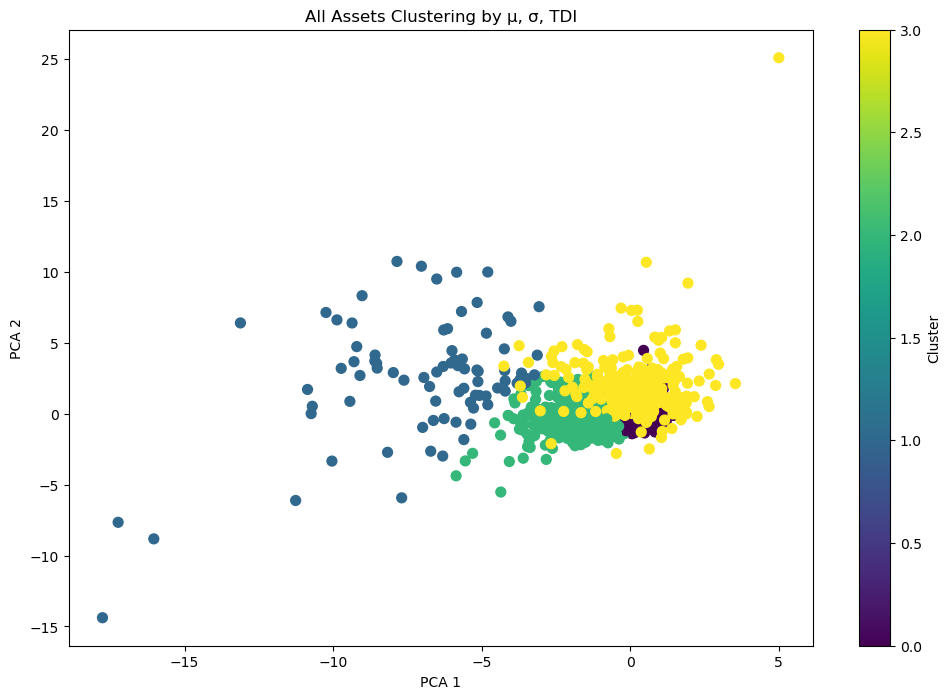


--- Cluster Summary ---
         Expected Return (mu)  Risk (sigma)  TDI (Tail Dependence)
Cluster                                                           
0                    0.223853      0.412948              -0.014178
1                   -4.281032      7.999595              -0.055236
2                   -0.746070      1.285554              -0.048065
3                    1.200970      3.574557               0.015040


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Рыночная доходность (среднее по всем активам)
market_returns = log_returns.mean(axis=1)

# 2. Порог худших 5% дней
threshold = market_returns.quantile(0.05)
tail_days = market_returns <= threshold

# 3. TDI для всех активов
tdi_values = log_returns[tail_days].mean(axis=0)

# 4. Добавляем TDI к asset_metrics
asset_metrics['TDI (Tail Dependence)'] = tdi_values

# 5. Выбираем признаки для кластеризации
features = ['Expected Return (mu)', 'Risk (sigma)', 'TDI (Tail Dependence)']
clustering_data = asset_metrics[features].dropna()

# 6. Нормировка
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# 7. KMeans кластеризация (4 кластера)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

clustering_data['Cluster'] = clusters

# 8. PCA для визуализации
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(scaled_data)

plt.figure(figsize=(12,8))
scatter = plt.scatter(pca_coords[:,0], pca_coords[:,1], c=clusters, cmap='viridis', s=50)
plt.title("All Assets Clustering by μ, σ, TDI")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.show()

# 9. Сводка по кластерам
cluster_summary = clustering_data.groupby('Cluster')[features].mean()
print("\n--- Cluster Summary ---")
print(cluster_summary)



Cluster 0: 4804 assets
['UCIX', 'WARM', 'VCOR', 'WBHC', 'MULG', 'UGLDF', 'HOVVB', 'ELLKF', 'HLLK', 'ZLME', 'HMDCF', 'ALPC', 'KWIK', 'DSLVF', 'CITY', 'WEWA', 'SCGY', 'XPTFX', 'CCLFX', 'NICHX'] ...

Cluster 1: 82 assets
['RNVA', 'IFMK', 'ATVK', 'CONC', 'DQWS', 'GWIN', 'NUMD', 'CNCN', 'OWCP', 'FCTI', 'GBUX', 'PTCO', 'EWLU', 'PTZH', 'HOMU', 'CLTH', 'MNIZ', 'CXCQ', 'BIIO', 'QIND'] ...

Cluster 2: 1380 assets
['CDRO', 'SFTBY', 'QTWO', 'SFTBF', 'IWML', 'CGNT', 'LVS', 'EGHT', 'SFUNY', 'ASMB', 'JTKWY', 'BABA', 'NOAH', 'PLMR', 'GORO', 'UPLD', 'EMX', 'NRDY', 'LPSN', 'VITL'] ...

Cluster 3: 274 assets
['DXLG', 'LWLG', 'MILC', 'EP', 'IRNS', 'CVAT', 'IVDA', 'DLPN', 'BICX', 'CYCA', 'TNLX', 'CAPC', 'LNDZF', 'KOAN', 'OMWS', 'INCR', 'TRCK', 'WBBA', 'FRTG', 'SBSAA'] ...


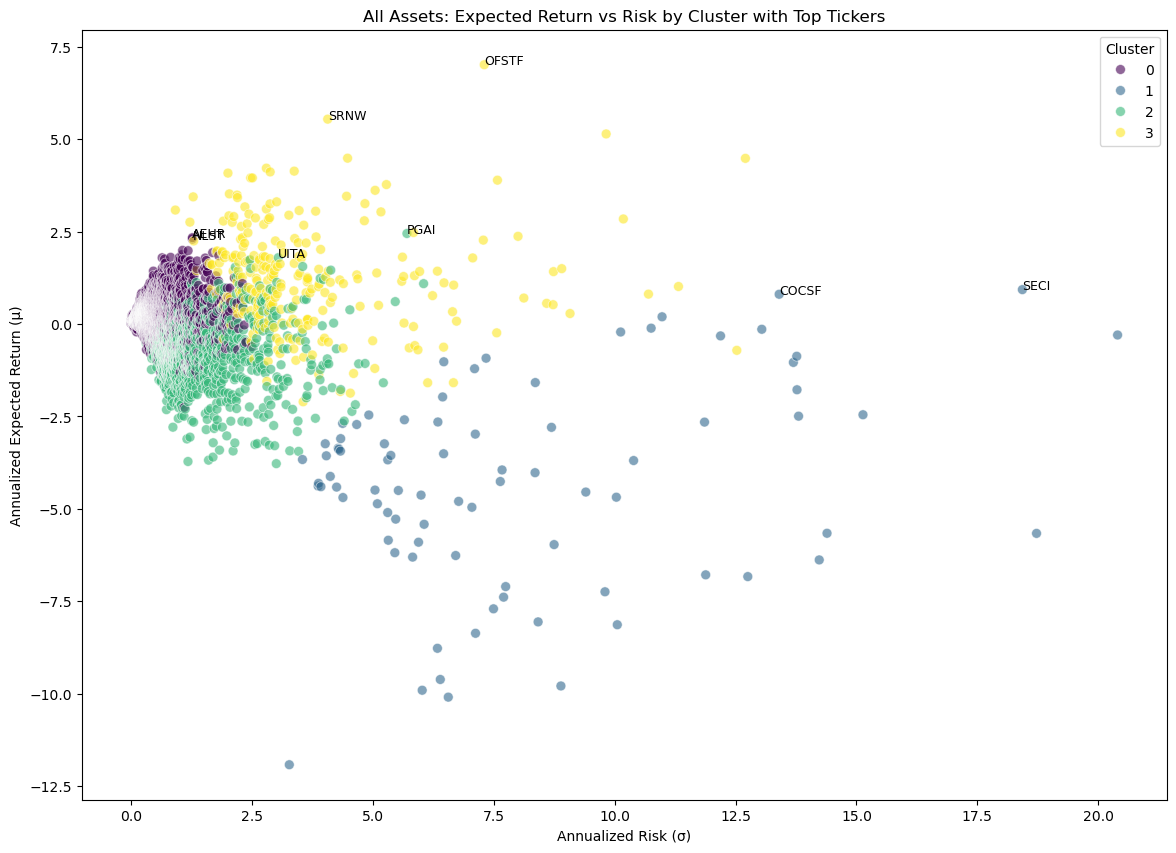

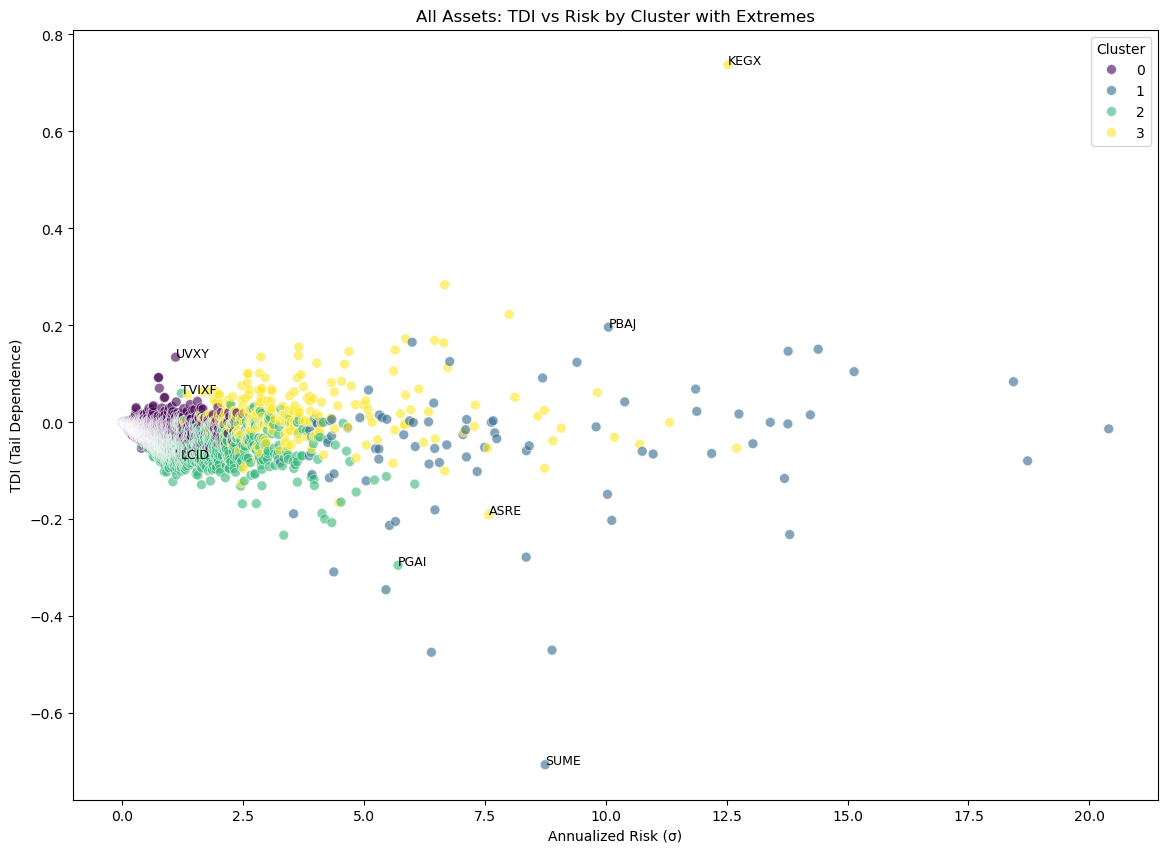

In [34]:
# Добавляем тикеры в clustering_data
clustering_data = clustering_data.copy()
clustering_data['Ticker'] = asset_metrics.index
clustering_data['Cluster'] = clusters

# --- 1. Список активов по кластерам ---
for c in sorted(clustering_data['Cluster'].unique()):
    tickers_in_cluster = clustering_data[clustering_data['Cluster'] == c]['Ticker'].tolist()
    print(f"\nCluster {c}: {len(tickers_in_cluster)} assets")
    print(tickers_in_cluster[:20], '...')  # выводим первые 20 для наглядности

# --- 2. Scatter plot μ vs σ с аннотацией тикеров (топовые по μ в каждом кластере) ---
plt.figure(figsize=(14,10))
sns.scatterplot(x='Risk (sigma)', y='Expected Return (mu)', hue='Cluster', palette='viridis', data=clustering_data, s=50, alpha=0.6)

# Аннотируем топ-2 активов по Expected Return в каждом кластере
for c in clustering_data['Cluster'].unique():
    cluster_df = clustering_data[clustering_data['Cluster'] == c]
    top_assets = cluster_df.nlargest(2, 'Expected Return (mu)')
    for _, row in top_assets.iterrows():
        plt.text(row['Risk (sigma)'], row['Expected Return (mu)'], row['Ticker'], fontsize=9)

plt.title("All Assets: Expected Return vs Risk by Cluster with Top Tickers")
plt.xlabel("Annualized Risk (σ)")
plt.ylabel("Annualized Expected Return (μ)")
plt.legend(title='Cluster')
plt.show()

# --- 3. TDI vs Risk с аннотацией топовых/наименее зависимых активов ---
plt.figure(figsize=(14,10))
sns.scatterplot(x='Risk (sigma)', y='TDI (Tail Dependence)', hue='Cluster', palette='viridis', data=clustering_data, s=50, alpha=0.6)

# Аннотируем топ-1 по TDI и минимальный TDI в каждом кластере
for c in clustering_data['Cluster'].unique():
    cluster_df = clustering_data[clustering_data['Cluster'] == c]
    top_tdi = cluster_df.nlargest(1, 'TDI (Tail Dependence)')
    low_tdi = cluster_df.nsmallest(1, 'TDI (Tail Dependence)')
    for _, row in pd.concat([top_tdi, low_tdi]).iterrows():
        plt.text(row['Risk (sigma)'], row['TDI (Tail Dependence)'], row['Ticker'], fontsize=9)

plt.title("All Assets: TDI vs Risk by Cluster with Extremes")
plt.xlabel("Annualized Risk (σ)")
plt.ylabel("TDI (Tail Dependence)")
plt.legend(title='Cluster')
plt.show()
